In [8]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [9]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
# sources = ["prefab4"]
sources = os.listdir(data_dir)
feat_dfs = []
label_dfs = []
for source in sources:
    # if source == "treebase_v1":
    #     continue
    feat_df = pd.read_parquet(data_dir / source / "features.parquet")
    label_df = pd.read_parquet(data_dir / source / "stats.parquet")
    label_df = label_df[["mean"]].query("method == 'dpos'").droplevel(2)
    feat_dfs.append(feat_df)
    label_dfs.append(label_df)

label_df = pd.concat(label_dfs, axis=0).sort_index()
# Scale up labels by ~10%
# label_df = (label_df * 1.1).clip(upper=1)
label_df = label_df / label_df.max()
feat_df = pd.concat(feat_dfs, axis=0).sort_index()
# feat_df = feat_df[top_feats[:20]]

if "is_dna" in feat_df:
    is_dna = feat_df.is_dna
    feat_df = feat_df.drop("is_dna", axis=1)
feat_df = feat_df.loc[:, ~feat_df.columns.str.endswith("monte-carlo-pi")]

assert (feat_df.index == label_df.index).all()

In [10]:
print(label_df.max())

mean    1.0
dtype: float64


In [11]:
print("Shape:", feat_df.shape)
max_nan_col = feat_df.isna().sum().sort_values(ascending=False).iloc[[0]]
print("NaN max count: ", max_nan_col.index[0], "->", int(max_nan_col.iloc[0]))
print("NaN col share:", (feat_df.isna().any().mean()))
print(feat_df.columns[feat_df.isna().any()].to_list())
print()
print("NaN Rows:")
nan_mask = feat_df.isna().any(axis=1)
feat_df[nan_mask]

Shape: (6567, 332)
NaN max count:  p95:tc_200_max -> 6172
NaN col share: 0.7951807228915663
['min:tc_min', 'max:tc_min', 'mean:tc_min', 'std:tc_min', 'p5:tc_min', 'p10:tc_min', 'p25:tc_min', 'p50:tc_min', 'p75:tc_min', 'p90:tc_min', 'p95:tc_min', 'min:tc_mean', 'max:tc_mean', 'mean:tc_mean', 'std:tc_mean', 'p5:tc_mean', 'p10:tc_mean', 'p25:tc_mean', 'p50:tc_mean', 'p75:tc_mean', 'p90:tc_mean', 'p95:tc_mean', 'min:tc_max', 'max:tc_max', 'mean:tc_max', 'std:tc_max', 'p5:tc_max', 'p10:tc_max', 'p25:tc_max', 'p50:tc_max', 'p75:tc_max', 'p90:tc_max', 'p95:tc_max', 'min:tc_base_min', 'max:tc_base_min', 'mean:tc_base_min', 'std:tc_base_min', 'p5:tc_base_min', 'p10:tc_base_min', 'p25:tc_base_min', 'p50:tc_base_min', 'p75:tc_base_min', 'p90:tc_base_min', 'p95:tc_base_min', 'min:tc_base_mean', 'max:tc_base_mean', 'mean:tc_base_mean', 'std:tc_base_mean', 'p5:tc_base_mean', 'p10:tc_base_mean', 'p25:tc_base_mean', 'p50:tc_base_mean', 'p75:tc_base_mean', 'p90:tc_base_mean', 'p95:tc_base_mean', 'min:

num_seqs  min:seq_length  max:seq_length  \
source      dataset                                                
arthropod   CYP_12           141             477             558   
            CYP_15           148             466             524   
            CYP_18           124             417             569   
            CYP_2             16             490             544   
            CYP_20            19             462             494   
...                          ...             ...             ...   
treebase_v1 9994_0.phy       114            1027            1387   
            9994_1.phy        64             668            1491   
            9996_0.phy        55             329             454   
            9996_1.phy        53             958            1084   
            9999_0.phy        66             834             847   

                        mean:seq_length  std:seq_length  p5:seq_length  \
source      dataset                                                      
arthropod   CYP_12           527.304965       13.154803         501.00   
            CYP_15           491.344595        7.691442         483.00   
            CYP_18           528.685484       16.380243         509.00   
            CYP_2            497.187500       12.890009         490.00   
            CYP_20           472.578947        7.995497         462.00   
...                                 ...             ...            ...   
treebase_v1 9994_0.phy      1359.368421       57.616436        1275.10   
            9994_1.phy      1372.859375      144.659176        1254.95   
            9996_0.phy       441.163636       23.123985         414.50   
            9996_1.phy      1068.245283       25.702878        1022.20   
            9999_0.phy       842.666667        2.494438         838.00   

                        p10:seq_length  p25:seq_length  p50:seq_length  \
source      dataset                                                      
arthropod   CYP_12               514.0           520.0           527.0   
            CYP_15               485.0           487.0           490.5   
            CYP_18               513.6           523.0           530.0   
            CYP_2                490.0           490.0           493.5   
            CYP_20               462.0           468.0           471.0   
...                                ...             ...             ...   
treebase_v1 9994_0.phy          1315.1          1346.0          1386.0   
            9994_1.phy          1337.1          1371.0          1405.0   
            9996_0.phy           434.4           446.0           448.0   
            9996_1.phy          1040.2          1072.0          1078.0   
            9999_0.phy           839.0           843.0           843.0   

                        p75:seq_length  ...  max:tc_200_max  mean:tc_200_max  \
source      dataset                     ...                                    
arthropod   CYP_12              536.00  ...             NaN              NaN   
            CYP_15              495.00  ...             NaN              NaN   
            CYP_18              538.00  ...             NaN              NaN   
            CYP_2               498.00  ...             NaN              NaN   
            CYP_20              477.00  ...             NaN              NaN   
...                                ...  ...             ...              ...   
treebase_v1 9994_0.phy         1387.00  ...             NaN              NaN   
            9994_1.phy         1432.25  ...             NaN              NaN   
            9996_0.phy          449.00  ...             NaN              NaN   
            9996_1.phy         1080.00  ...             NaN              NaN   
            9999_0.phy          843.00  ...             NaN              NaN   

                        std:tc_200_max  p5:tc_200_max  p10:tc_200_max  \
source      dataset                                                     
arthropod   CYP_12        

In [12]:
mask = (feat_df["num_seqs"] >= 3).to_numpy()
print(f"Dropping {sum(~mask)} NaN rows...")
feat_df = feat_df[mask]
label_df = label_df[mask]

Dropping 5 NaN rows...


In [13]:
print(feat_df.num_seqs.max())
print(feat_df["max:seq_length"].max())

233
7954


In [14]:
sample = np.random.randint(0, len(label_df), int(len(label_df) * 0.75))
train_idxs = label_df.iloc[sample].index
test_idxs = feat_df.drop(feat_df.iloc[sample].index).index
assert len(set(train_idxs).intersection(set(test_idxs))) == 0

In [15]:
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# selector = SequentialFeatureSelector(
#     LinearRegression(), n_features_to_select=30
# )
# model = HistGradientBoostingRegressor(
#     max_features=0.1,
#     max_depth=7,
#     # learning_rate=0.05,
#     max_leaf_nodes=None,
#     max_iter=800,
#     # loss="absolute_error",
# )
model = RandomForestRegressor(
    max_features=0.1,
    max_depth=7,
    # learning_rate=0.05,
    max_leaf_nodes=None,
    # max_iter=100,
    # loss="absolute_error",
)
# model = LinearRegression()
# pipeline = Pipeline([("select", selector), ("model", model)])
pipeline = Pipeline([("model", model)])
# model = GradientBoostingRegressor()
# model = LinearRegression()
pipeline.fit(feat_df.loc[train_idxs], label_df.loc[train_idxs].to_numpy().ravel())
y_pred = pipeline.predict(feat_df.loc[test_idxs]).clip(min=0, max=1)

In [16]:
y_true = label_df.loc[test_idxs].to_numpy().ravel()
rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
corr = np.corrcoef(y_true, y_pred)[0, 1]
print(f"[RMSE] {rmse:.4f}")
print(f"[CORR] {corr:.4f}")

[RMSE] 0.0604
[CORR] 0.9462


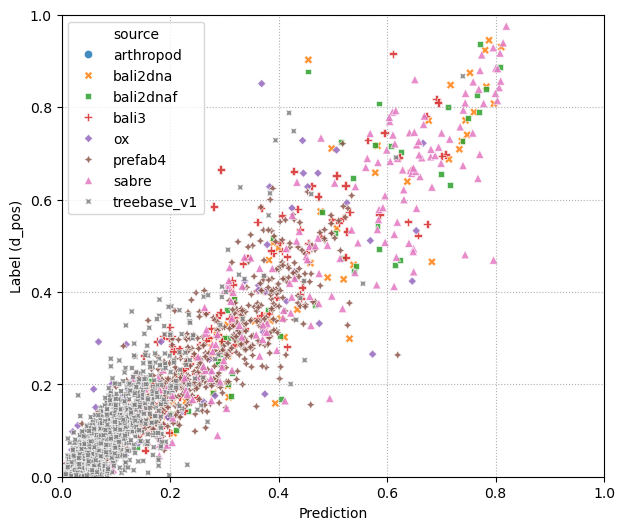

In [17]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[test_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

Index(['mean:tc_min', 'p50:tc_mean', 'mean:tc_mean', 'p50:tc_min',
       'mean:tc_max', 'p75:tc_min', 'p75:tc_mean', 'p25:tc_min', 'p25:tc_mean',
       'p75:tc_max', 'p50:tc_max', 'p25:tc_max', 'p90:tc_mean', 'p10:tc_max',
       'p90:tc_min'],
      dtype='object')


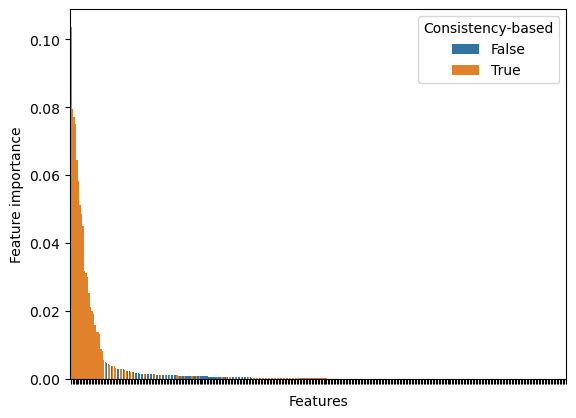

In [22]:
importance = model.feature_importances_
sort_idxs = np.argsort(importance)[::-1]
top_feats = feat_df.columns[sort_idxs]
is_tc = top_feats.str.contains("tc")
sn.barplot(x=top_feats, y=importance[sort_idxs], hue=is_tc)
ax = plt.gca()
_ = ax.set_xticklabels([])
_ = ax.legend(title="Consistency-based")
_ = ax.set_ylabel("Feature importance")
_ = ax.set_xlabel("Features")
print(top_feats[:15])